In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

None

In [2]:
#%run -i -e read_counts.py
all_freqs = pickle.load(open('all_freqs.pkl', 'rb'))

In [3]:
sample_info = pd.read_excel('Sample_Info_FIXED2.xlsx') ##,skiprows=[0])
sample_info = sample_info.drop( ['growth rate per h (OLD)', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Sample name.1'], 1)
sample_info = sample_info.set_index( sample_info['Sample name'] )
#%store sample_info 
#%store all_freqs   ## cool! saved in ~/.ipython/profile_default/db/autorestore/

In [4]:
##%who_ls
#%store -r all_freqs
#%store -r sample_info   ## seems to mess up the indexing

sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
info_g20 = sample_infos['Desulfovibrio_alaskensis_G20_uid57941'].copy()
sizeme(info_g20.head(3))

#( (info_g20['electron donor']=='lactate').values | (info_g20['electron donor']=='pyruvate').values ) & \
#(info_g20['organisms']=='D. alaskensis G20').values ## only mono-culture (i.e., single organism)

#info_g20a = info_g20[( (info_g20['electron donor']=='lactate').values | (info_g20['electron donor']=='pyruvate').values ) & \
#(info_g20['organisms']=='D. alaskensis G20').values]
#print(info_g20a.shape)
#sizeme(info_g20a.head(),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_ISB-1,Sample_ISB-1,Genewiz,SS01-ISB1,LS 37C G20 log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D. alaskensis G20,0.027
Sample_ISB-10,Sample_ISB-10,Genewiz,SS10-ISB10,PS 37C G20 e. stat 1,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035
Sample_ISB-11,Sample_ISB-11,Genewiz,SS11-ISB11,PS 37C G20 e. stat 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035


In [5]:
info_dvh = sample_infos['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sizeme(info_dvh.head(3))

#( (info_dvh['electron donor']=='lactate').values | (info_dvh['electron donor']=='pyruvate').values ) & \
#(info_dvh['organisms']=='D vulgaris Hildenborugh').values ## only mono-culture (i.e., single organism)

#info_dvha = info_dvh[( (info_dvh['electron donor']=='lactate').values | (info_dvh['electron donor']=='pyruvate').values ) & \
#(info_dvh['organisms']=='D vulgaris Hildenborugh').values]
#print(info_dvha.shape)
#sizeme(info_dvha.head(),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_US-1505885,Sample_US-1505885,Labcorp,US-1505885,PS 37 C log 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",sulfate respiration/growth,pyruvate 80mM,pyruvate,NaN,sulfate,0.13,37,D vulgaris Hildenborugh,NaN
Sample_US-1505888,Sample_US-1505888,Labcorp,US-1505888,LS 37C log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,0.11,37,D vulgaris Hildenborugh,NaN
Sample_US-1505895,Sample_US-1505895,Labcorp,US-1505895,LS 37C e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0.00,37,D vulgaris Hildenborugh,0


## Set up the expression data, separate for the 2 organisms, convert to ranks

In [6]:
%Rpush info_g20
x_g20 = all_freqs['Desulfovibrio_alaskensis_G20_uid57941'].copy()
print x_g20.shape
%Rpush x_g20
genes_g20 = x_g20.index.values.astype('str')
%Rpush genes_g20
%R -n colnames(x_g20) <- gsub('X..','',gsub('...1.','',colnames(x_g20),fixed=T),fixed=T)

%Rpush info_dvh
x_dvh = all_freqs['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
print x_dvh.shape
%Rpush x_dvh
genes_dvh = x_dvh.index.values.astype('str')
%Rpush genes_dvh
%R -n colnames(x_dvh) <- gsub('X..','',gsub('...1.','',colnames(x_dvh),fixed=T),fixed=T)

#%R save.image('qqq')

(3369, 30)
(3648, 57)


## Filter out the bad rows (i.e., not genes) from the data

In [7]:
%%R -n
good_gene = which(!substr(genes_g20,1,2)=='__' & apply(x_g20,1,sum)>0)
x_g20 = x_g20[good_gene,]
x_g20.orig = x_g20 = as.matrix(x_g20)
rownames(x_g20)=genes_g20[good_gene]

good_gene = which(!substr(genes_dvh,1,2)=='__' & apply(x_dvh,1,sum)>0)
x_dvh = x_dvh[good_gene,]
x_dvh.orig = x_dvh = as.matrix(x_dvh)
rownames(x_dvh)=genes_dvh[good_gene]
#save.image('qqq')

In [8]:
#%store -r blast_out
#%Rpush blast_out
%R load('blasting.RData')
%Rpull blast_out
sizeme(blast_out.head())

,Subject.id,Query.id,X..identity,alignment.length,mismatches,gap.openings,q..start,q..end,s..start,s..end,e.value,bit.score,fraction.x,fraction.y,names.x,names.y,names.x.1,names.y.1,names.x.2,names.y.2
0,2765,2875,85.36,1380,201,1,1,1380,1,1379,0,2420,0.996390,0.995671,Dde_2998,DVU2929,Dde_2998,DVU2929,Dde_2998,DVU2929
1,2764,2874,83.70,1368,222,1,1,1367,1,1368,0,2385,0.997085,0.994909,Dde_2997,DVU2928,Dde_2997,DVU2928,Dde_2997,DVU2928
2,2854,3106,82.68,1218,207,3,1,1217,1,1215,0,2106,1.002469,1.000822,Dde_3237,DVU3025,Dde_3237,DVU3025,Dde_3237,DVU3025
3,1803,2009,79.81,1233,249,0,1,1233,1,1233,0,2079,0.999190,0.995961,Dde_2081,DVU1834,Dde_2081,DVU1834,Dde_2081,DVU1834
4,1802,2008,79.82,1194,238,2,1,1194,1,1191,0,1985,1.002519,1.000000,Dde_2080,DVU1833,Dde_2080,DVU1833,Dde_2080,DVU1833


In [9]:
%%R
x_g20 = x_g20[ rownames(x_g20) %in% blast_out$names.x, ]
x_g20.ranks <- apply(x_g20,2,rank)
x_dvh = x_dvh[ rownames(x_dvh) %in% blast_out$names.y, ]
x_dvh.ranks <- apply(x_dvh,2,rank)
#save.image('qqq')

## Set up the variables and data - training and test
## Also, map the rows in the test data to the orthologs' names in the training data

In [10]:
%Rpush info_g20
%Rpush info_dvh
#%R save.image('qqq')

In [12]:
%%R -n
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)

do_it_train <- function(cond_type, x_train, info_train,  
                  cols_exclude=NULL, genes_exclude=NULL, n_trees=100000) {
    
    info <- info_train
    x <- x_train
    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'organisms') {
        Y <- as.factor(as.character(info$organisms))
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    #cat(cond_type, length(levels(Y)), '\n')
    names(Y) <- info$Sample.name

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    if ( TRUE ) { ## preselect features using Boruta -- faster, and same results?
        B.temp1a <- Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0)
        features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    } else {
        features <- rownames(XX)
    }
        
    rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    
    cols_exclude2 <- cols_exclude
    if (cols2 == '') {
        cols2 <- colnames(x)
        cols_exclude2 <- gsub('.','-',cols2,fixed=T)
    }
        
    tmp <- list(predicted=predict(rf.temp1a, t(x[features,cols2,drop=F])), actual=Y[cols_exclude2], 
                features=features, classifier=rf.temp1a)
    
    return(tmp)
}
    
#############################################
#############################################
#############################################
#############################################

do_it_test <- function(tmp, cond_type, x_test, info_test, 
            cols_exclude=NULL, genes_exclude=NULL) {

    info <- info_test
    x <- x_test

    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'organisms') {
        Y <- as.factor(as.character(info$organisms))
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    #cat(cond_type, length(levels(Y)), '\n')
    names(Y) <- info$Sample.name

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    #B.temp1a <- Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0)
    #features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    
    #rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    cols_exclude2 <- cols_exclude
    if (cols2 == '') {
        cols2 <- colnames(x)
        cols_exclude2 <- gsub('.','-',cols2,fixed=T)
    }

    predicted1 <- predict(tmp$classifier, t(x[tmp$features,cols2,drop=F]))
    predicted2 <- predict(tmp$classifier, t(x[tmp$features,cols2,drop=F]), type='prob')

    tmp2 <- list(predicted=predicted1, predictedProbs=predicted2, actual=Y[cols_exclude2])
    
    return(list(testOnTrain=tmp, testOnTest=tmp2, classifier=tmp$classifier, features=tmp$features))
}

rm(tmp, tmp2)
#save.image('qqq')
NULL

NULL


### Train on G20, test on DvH 

In [21]:
%%R
x_train <- x_g20.ranks
info_train <- info_g20
x_train = x_train[,gsub('.','-',colnames(x_train),fixed=T) %in% info_train$Sample.name]; print(dim(x_train))

x_test <- x_dvh.ranks
info_test <- info_dvh
x_test = x_test[,gsub('.','-',colnames(x_test),fixed=T) %in% info_test$Sample.name]; print(dim(x_test))

mapping <- as.character(blast_out$names.x)
names(mapping) <- as.character(blast_out$names.y)
rownames(x_test) <- mapping[rownames(x_test)]
x_test = x_test[ rownames(x_train), ]

#save.image('15a. trainOnG20_testOnDvH.RData')

[1] 2125   30
[1] 2125   57


## Electron donor:

In [16]:
%%R
tmp <- do_it_train('electron_donor', x_train, info_train, 
                  cols_exclude=NULL, genes_exclude=NULL, n_trees=100000)
tmp2 <- do_it_test(tmp, 'electron_donor', x_test, info_test, 
                  cols_exclude=NULL, genes_exclude=NULL)
print(mean(as.character(tmp2$testOnTest$predicted)==as.character(tmp2$testOnTest$actual)))

[1] 0.6315789


## Electron acceptor:

In [17]:
%%R
tmp <- do_it_train('electron_acceptor', x_train, info_train, 
                  cols_exclude=NULL, genes_exclude=NULL, n_trees=100000)
tmp2 <- do_it_test(tmp, 'electron_acceptor', x_test, info_test, 
                  cols_exclude=NULL, genes_exclude=NULL)
print(mean(as.character(tmp2$testOnTest$predicted)==as.character(tmp2$testOnTest$actual)))

[1] 0.4561404


## Temperature:

In [18]:
%%R
tmp <- do_it_train('temperature', x_train, info_train, 
                  cols_exclude=NULL, genes_exclude=NULL, n_trees=100000)
tmp2 <- do_it_test(tmp, 'temperature', x_test, info_test, 
                  cols_exclude=NULL, genes_exclude=NULL)
print(mean(as.character(tmp2$testOnTest$predicted)==as.character(tmp2$testOnTest$actual)))

[1] 0.6140351


## Mono- or co-culture:
#### need to update the info table to be the same between the two

In [22]:
%%R
info_train$organisms <- as.factor(ifelse(as.character(info_train$organisms)=='D. alaskensis G20', 'monoculture', 'coculture'))
info_test$organisms <- as.factor(ifelse(as.character(info_test$organisms)=='D vulgaris Hildenborugh', 'monoculture', 'coculture'))

tmp <- do_it_train('organisms', x_train, info_train, 
                  cols_exclude=NULL, genes_exclude=NULL, n_trees=100000)
tmp2 <- do_it_test(tmp, 'organisms', x_test, info_test, 
                  cols_exclude=NULL, genes_exclude=NULL)
print(mean(as.character(tmp2$testOnTest$predicted)==as.character(tmp2$testOnTest$actual)))

[1] 0.6491228


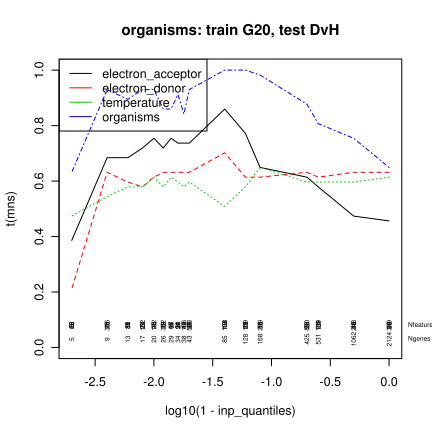

In [23]:
%%R
save.image('15a. trainOnG20_testOnDvH.RData')
#load('qqq')
#require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)
cond_type <- 'electron_acceptor'
qqq <- list()
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))

if ('D vulgaris Hildenborough' %in% info_test$organisms) {
    info_train$organisms <- as.factor(ifelse(as.character(info_train$organisms)=='D. alaskensis G20', 'monoculture', 'coculture'))
    info_test$organisms <- as.factor(ifelse(as.character(info_test$organisms)=='D vulgaris Hildenborugh', 'monoculture', 'coculture'))
}

mns <- apply(x_train, 1, median)
levels <- quantile(mns, inp_quantiles)

for (cond_type in c('electron_acceptor', 'electron_donor', 'temperature', 'organisms')) {
tmp <- mclapply( rev(levels), function(lev) {
    cat(cond_type, rev(names(levels))[which(rev(levels)==lev)], lev, sum(mns>lev), '\n')
    xx <- x_train[mns > lev,, drop=F]
    tmpa <- do_it_train(cond_type, xx, info_train, n_trees=100000)
    xxx <- x_test[mns > lev,, drop=F]
    tmp2a <- do_it_test(tmpa, cond_type, xxx, info_test)
    print(mean(as.character(tmp2a$testOnTest$predicted)==as.character(tmp2a$testOnTest$actual)))
    return(tmp2a)
}, mc.preschedule=F )
qqq[[cond_type]] <- tmp
}
rm(tmp)

for (cond_type in c('electron_acceptor', 'electron_donor', 'temperature', 'organisms')) {
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
for (i in 1:length(qqq[[cond_type]])) { 
    if (object.size(qqq[[cond_type]][[i]]) <= 3000) 
        qqq[[cond_type]][[i]] <- list(testOnTrain=list(predicted=factor(),actual=factor(),features=character()),
                                        testOnTest=list(predicted=factor(),actual=factor(),predictedProbs=matrix()),
                                        features=NULL)
}     
}
    
mns <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,
                                    function(tmp1)mean(as.character(tmp1[[lev]]$testOnTest$predicted) ==
                                        as.character(tmp1[[lev]]$testOnTest$actual), na.rm=T)))
names(mns)<-names(qqq[[cond_type]])
mns<-mns[,ncol(mns):1]
expr_levels = quantile(apply(x_train,1,median),inp_quantiles)
n_genes <- sapply(expr_levels,function(lev)sum(apply(x_train,1,median)>lev))

n_features <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,
                                    function(tmp1)length(tmp1[[lev]]$features)))
names(n_features)<-names(qqq[[cond_type]][[1]])
n_features<-n_features[length(n_features):1]

matplot(log10(1-inp_quantiles),t(mns),typ='l',main=sprintf('%s: train G20, test DvH',cond_type), ylim=c(0.0,1.0))
legend('topleft',legend=names(qqq),lwd=1,col=1:4)
#text(log10(1-inp_quantiles), 0.5, lab=as.character(round(expr_levels)),cex=0.5,srt=90, xpd=NA)
#text(0.1, 0.5, lab='Rank', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.03, lab=as.character(n_genes),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.03, lab='Ngenes', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.08, lab=as.character(round(n_features)),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.08, lab='Nfeatures', pos=4, cex=0.5, xpd=NA)
                                        
save.image('15a. trainOnG20_testOnDvH.RData')